In [1]:
import quadpy
import scipy
import matplotlib.pyplot as plt
import numpy as np
import bemcs

# Define point source functions

In [2]:
def laplacian_pointforce_disp(x, y, xs, ys, f=1, mu=1):
    """
    Calculate the displacement due to a point force.

    Parameters:
    x, y : float or numpy array
        Coordinates where the displacement is to be calculated.
    xs, ys : float
        Coordinates of the source point force.
    f : float
        applied force

    Returns:
    u : float or numpy array
        Displacement at the given coordinates.
    """
    r = np.sqrt((x - xs) ** 2 + (y - ys) ** 2)
    u = f / (2 * np.pi * mu) * np.log(r)
    return u


def laplacian_pointforce_sx(x, y, xs, ys, f=1):
    """
    Calculate the stress component sx due to a point force.

    Parameters:
    x, y : float or numpy array
        Coordinates where the stress is to be calculated.
    xs, ys : float
        Coordinates of the source point force.
    f : float
        applied force

    Returns:
    sx : float or numpy array
        Stress component sx at the given coordinates.
    """
    r = np.sqrt((x - xs) ** 2 + (y - ys) ** 2)
    sx = f / np.pi * (x - xs) / (r**2)
    return sx


def laplacian_pointforce_sy(x, y, xs, ys, f=1):
    """
    Calculate the stress component sy due to a point force.

    Parameters:
    x, y : float or numpy array
        Coordinates where the stress is to be calculated.
    xs, ys : float
        Coordinates of the source point force.
    f : float
        applied force

    Returns:
    sy : float or numpy array
        Stress component sy at the given coordinates.
    """
    r = np.sqrt((x - xs) ** 2 + (y - ys) ** 2)
    sy = f / np.pi * (y - ys) / (r**2)
    return sy

# Functions to carry out integration

In [3]:
def get_transformed_coordinates(vertices, obs_x, obs_y):
    """
    Transform coordinates by translating and rotating the triangle and observation points.

    This function translates the triangle such that the first vertex is at the origin, then rotates
    the triangle and the observation points so that the second vertex aligns with the positive y-axis.

    Parameters:
    -----------
    vertices : numpy.ndarray
        An array of shape (3, 2) representing the coordinates of the triangle's vertices.
    obs_x : numpy.ndarray
        An array of x-coordinates of the observation points.
    obs_y : numpy.ndarray
        An array of y-coordinates of the observation points.

    Returns:
    --------
    rotated_vertices : numpy.ndarray
        The transformed coordinates of the triangle's vertices.
    rotated_obs_x : numpy.ndarray
        The transformed x-coordinates of the observation points.
    rotated_obs_y : numpy.ndarray
        The transformed y-coordinates of the observation points.

    Notes:
    ------
    The function performs the following steps:
    1. Translates the triangle so that the first vertex is at the origin.
    2. Calculates the angle required to rotate the second vertex to align with the positive y-axis.
    3. Constructs a rotation matrix using the calculated angle.
    4. Applies the translation and rotation transformations to both the triangle's vertices and the observation points.
    """
    # Translate the triangle so that the first vertex is at the origin
    translated_vertices = vertices - np.array(vertices[0])
    translated_obs_x = obs_x - vertices[0, 0]
    translated_obs_y = obs_y - vertices[0, 1]

    # Determine the angle to rotate the second vertex to align with the y-axis
    second_vertex = translated_vertices[1]
    angle = np.arctan2(second_vertex[0], second_vertex[1])

    # Rotation matrix to align the second vertex along the positive y-axis
    rotation_matrix = np.array(
        [[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]
    )
    rotated_vertices = np.dot(translated_vertices, rotation_matrix.T)
    rotated_obs = np.dot(
        np.array([translated_obs_x, translated_obs_y]).T, rotation_matrix.T
    )

    return rotated_vertices, rotated_obs[:, 0], rotated_obs[:, 1]


def get_triangle_area(lx, ly, dly):
    """
    Calculate the area of a triangle using the lengths of its sides.

    This function calculates the area of a triangle given the coordinates of its vertices using
    Heron's formula. The vertices are assumed to be at (0, 0), (lx, dly), and (0, ly).

    Parameters:
    -----------
    lx : float
        The x-coordinate of the second vertex of the triangle.
    ly : float
        The y-coordinate of the third vertex of the triangle.
    dly : float
        The y-coordinate of the second vertex of the triangle.

    Returns:
    --------
    triangle_area : float
        The area of the triangle.

    Notes:
    ------
    The function performs the following steps:
    1. Calculates the lengths of the sides of the triangle using the distance formula.
    2. Computes the semi-perimeter of the triangle.
    3. Applies Heron's formula to find the area of the triangle.
    """
    a = np.sqrt((lx - 0) ** 2 + (dly - 0) ** 2)
    b = np.sqrt((0 - lx) ** 2 + (ly - dly) ** 2)
    c = np.sqrt((0 - 0) ** 2 + (0 - ly) ** 2)

    # Calculate the semi-perimeter of the triangle
    s = (a + b + c) / 2

    # Calculate the area of the triangle using Heron's formula
    triangle_area = np.sqrt(s * (s - a) * (s - b) * (s - c))
    return triangle_area


def rotate_vector(vertices, fx, fy, rotdir=1):
    """
    Rotate a vector to a new coordinate system aligned with the triangle's edge.

    This function rotates a force vector (fx, fy) to a new coordinate system such that the
    edge between the first and second vertices of the triangle aligns with the positive y-axis.
    The rotation is performed using the specified rotation direction.

    Parameters:
    -----------
    vertices : numpy.ndarray
        An array of shape (3, 2) representing the coordinates of the triangle's vertices.
    fx : numpy.ndarray
        The x-component of the force vector to be rotated.
    fy : numpy.ndarray
        The y-component of the force vector to be rotated.
    rotdir : int, optional
        The direction of rotation. Default is 1 (counterclockwise). Use -1 for clockwise rotation.

    Returns:
    --------
    fx_rotated : numpy.ndarray
        The rotated x-component of the force vector.
    fy_rotated : numpy.ndarray
        The rotated y-component of the force vector.

    Notes:
    ------
    The function performs the following steps:
    1. Determines the rotation angle required to align the second vertex of the triangle with the positive y-axis.
    2. Constructs the rotation matrix using the calculated angle.
    3. Applies the rotation matrix to the force vector.
    4. Returns the rotated force vector components.
    """
    angle = (
        np.arctan2(vertices[1, 0] - vertices[0, 0], vertices[1, 1] - vertices[0, 1])
    ) * rotdir

    # Rotation matrix to align the second vertex along the positive y-axis
    rotation_matrix = np.array(
        [[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]
    )
    rotated_vector = np.dot(np.hstack([fx, fy]), rotation_matrix.T)
    fx_rotated = rotated_vector[:, 0]
    fy_rotated = rotated_vector[:, 1]

    return fx_rotated, fy_rotated


def displacements_stresses_triangle_force_antiplane_nearfield(
    triangle, x_obs, y_obs, fval, mu
):
    """
    Calculate the near-field displacements and stresses at observation points due to forces on a triangular element in antiplane.

    This function computes the displacements and stresses (sx, sy) at specified observation points
    resulting from forces applied to a triangular element under the assumption of antiplane conditions.
    The calculations use the point source solution and integrate over the triangular element using
    double integration.

    Parameters:
    -----------
    triangle : numpy.ndarray
        An array of shape (3, 2) representing the coordinates of the triangle's vertices.
    x_obs : numpy.ndarray
        A 2D array representing the x-coordinates of the observation points.
    y_obs : numpy.ndarray
        A 2D array representing the y-coordinates of the observation points.
    f : float
        The applied force.
    mu : float
        The shear modulus of the material.

    Returns:
    --------
    u : numpy.ndarray
        The displacements at the observation points.
    sx : numpy.ndarray
        The x-component of the stress at the observation points.
    sy : numpy.ndarray
        The y-component of the stress at the observation points.

    Notes:
    ------
    The function performs the following steps:
    1. Flattens the observation coordinates.
    2. Transforms the triangle and observation coordinates to a local coordinate system.
    3. Rotates the force vector to the local coordinate system.
    4. Defines the integration limits over the transformed triangle.
    5. Performs double integration using the point source solution to compute displacements and stresses.
    6. Rotates the results back to the original coordinate system.

    Integration is performed using `scipy.integrate.dblquad` with a specified absolute error tolerance.
    """

    DBLQUAD_TOLERANCE = 1e-3

    # Flatten passed observations coordinates
    x_obs = x_obs.flatten()
    y_obs = y_obs.flatten()

    # Shape forces
    fval = np.array([fval])[:, None]

    # Translate and rotate the triangle
    triangle_transformed, obs_x_transformed, obs_y_transformed = (
        get_transformed_coordinates(triangle, x_obs, y_obs)
    )

    # Define a triangle region in dblquad style
    lx = triangle_transformed[2, 0]
    dly = triangle_transformed[2, 1]
    ly = triangle_transformed[1, 1]

    triangle_area = get_triangle_area(lx, ly, dly)

    # Definition of integration limits over a triangle and integrate using rotated forces
    ymin = lambda x: dly * x / lx
    ymax = lambda x: ly - (ly - dly) * x / lx

    u_dblquad = np.zeros_like(obs_x_transformed)
    sx_dblquad = np.zeros_like(obs_x_transformed)
    sy_dblquad = np.zeros_like(obs_x_transformed)

    for i in range(0, obs_x_transformed.size):
        # u integration
        f = lambda y, x: laplacian_pointforce_disp(
            obs_x_transformed[i],
            obs_y_transformed[i],
            x,
            y,
            fval,
            mu,
        )
        sol, err = scipy.integrate.dblquad(
            f, 0, lx, ymin, ymax, epsabs=DBLQUAD_TOLERANCE
        )
        if lx < 0:
            u_dblquad[i] = -sol / triangle_area
        else:
            u_dblquad[i] = sol / triangle_area

        # x stress integration
        f = lambda y, x: laplacian_pointforce_sx(
            obs_x_transformed[i], obs_y_transformed[i], x, y, fval
        )
        sol, err = scipy.integrate.dblquad(
            f, 0, lx, ymin, ymax, epsabs=DBLQUAD_TOLERANCE
        )
        sx_dblquad[i] = sol / triangle_area
        if lx < 0:
            sx_dblquad[i] = -sol / triangle_area
        else:
            sx_dblquad[i] = sol / triangle_area

        # y stress integration
        f = lambda y, x: laplacian_pointforce_sy(
            obs_x_transformed[i], obs_y_transformed[i], x, y, fval
        )
        sol, err = scipy.integrate.dblquad(
            f, 0, lx, ymin, ymax, epsabs=DBLQUAD_TOLERANCE
        )
        sy_dblquad[i] = sol / triangle_area
        if lx < 0:
            sy_dblquad[i] = -sol / triangle_area
        else:
            sy_dblquad[i] = sol / triangle_area

    # Rotate back to original coordinates
    sx, sy = rotate_vector(
        triangle,
        sx_dblquad.reshape(-1, 1),
        sy_dblquad.reshape(-1, 1),
        -1,
    )

    return u_dblquad, sx, sy


def displacements_stresses_triangle_force_antiplane_farfield(
    triangle, x_obs, y_obs, fval, mu
):
    """
    Calculate the far-field displacements and stresses at observation points due to forces on a triangular element in antiplane.

    This function computes the displacements and stresses (sx, sy) at specified observation points
    resulting from forces applied to a triangular element under the assumption of antiplane conditions.
    The calculations use the point source solution and integrate over the triangular element using
    a quadrature scheme.

    Parameters:
    -----------
    triangle : numpy.ndarray
        An array of shape (3, 2) representing the coordinates of the triangle's vertices.
    x_obs : numpy.ndarray
        A 2D array representing the x-coordinates of the observation points.
    y_obs : numpy.ndarray
        A 2D array representing the y-coordinates of the observation points.
    fval : float
        The applied force.
    mu : float
        The shear modulus of the material.

    Returns:
    --------
    u : numpy.ndarray
        The displacements at the observation points.
    sx : numpy.ndarray
        The x-component of the stress at the observation points.
    sy : numpy.ndarray
        The y-component of the stress at the observation points.

    Notes:
    ------
    The function uses the `quadpy` library to perform numerical integration over the triangular element
    using a quadrature scheme with N_INTEGRATION_POINTS integration points. The Kelvin point source solution is used
    to compute the displacements and stresses due to the applied forces.
    """
    x_obs = x_obs.flatten()
    y_obs = y_obs.flatten()
    u = np.zeros_like(x_obs)
    sx = np.zeros_like(x_obs)
    sy = np.zeros_like(x_obs)

    # quadpy integration scheme
    N_INTEGRATION_POINTS = 20
    scheme = quadpy.t2.get_good_scheme(N_INTEGRATION_POINTS)
    points_new = np.dot(triangle.T, scheme.points)
    n_integration_pts = len(scheme.weights)

    for i in range(n_integration_pts):
        u_i = laplacian_pointforce_disp(
            x_obs, y_obs, points_new[0, i], points_new[1, i], fval, mu
        )
        u += scheme.weights[i] * u_i

        sx_i = laplacian_pointforce_sx(
            x_obs, y_obs, points_new[0, i], points_new[1, i], fval
        )
        sy_i = laplacian_pointforce_sy(
            x_obs, y_obs, points_new[0, i], points_new[1, i], fval
        )
        sx += scheme.weights[i] * sx_i
        sy += scheme.weights[i] * sy_i
    return u, sx, sy


def displacements_stresses_triangle_force_antiplane(
    triangle, x_obs, y_obs, fval=1.0, mu=1.0
):
    """
    Calculate displacements and stresses for a given triangular element at specified observation points.

    This function determines the displacements and stresses at observation points by combining near-field
    and far-field solutions based on the distance of the observation points from the centroid of the triangle.

    Parameters:
    -----------
    triangle : numpy.ndarray
        An array of shape (3, 2) representing the coordinates of the triangle's vertices.
    x_obs : numpy.ndarray
        A 2D array representing the x-coordinates of the observation points.
    y_obs : numpy.ndarray
        A 2D array representing the y-coordinates of the observation points.
    f : float
        The force applied
    mu : float
        The shear modulus of the material.

    Returns:
    --------
    u : numpy.ndarray
        A 2D array of the displacements at the observation points.
    sx : numpy.ndarray
        A 2D array of the normal stress component in the x-direction at the observation points.
    sy : numpy.ndarray
        A 2D array of the normal stress component in the y-direction at the observation points.

    Notes:
    ------
    The function distinguishes between near-field and far-field observation points using a predefined
    distance cutoff. Near-field solutions are computed using the `get_displacements_stresses_nearfield`
    function, while far-field solutions are computed using the `get_displacements_stresses_farfield` function.

    """
    NEAR_FAR_DISTANCE_CUTOFF = 3.0
    obs_distances_from_centroid = scipy.spatial.distance.cdist(
        np.array([np.mean(triangle[:, 0]), np.mean(triangle[:, 1])])[:, None].T,
        np.array([x_obs.flatten(), y_obs.flatten()]).T,
    ).flatten()
    near_idx = np.where(obs_distances_from_centroid <= NEAR_FAR_DISTANCE_CUTOFF)[0]
    far_idx = np.where(obs_distances_from_centroid > NEAR_FAR_DISTANCE_CUTOFF)[0]

    u = np.zeros_like(x_obs)
    sx = np.zeros_like(x_obs)
    sy = np.zeros_like(x_obs)
    u_far, sx_far, sy_far = displacements_stresses_triangle_force_antiplane_farfield(
        triangle, x_obs[far_idx], y_obs[far_idx], fval, mu
    )
    u_near, sx_near, sy_near = (
        displacements_stresses_triangle_force_antiplane_nearfield(
            triangle, x_obs[near_idx], y_obs[near_idx], fval, mu
        )
    )
    u[far_idx] = u_far
    sx[far_idx] = sx_far
    sy[far_idx] = sy_far

    u[near_idx] = u_near
    sx[near_idx] = sx_near
    sy[near_idx] = sy_near

    return u, sx, sy

# Construct triangle and compute u,σ

/Users/mallick/miniconda3/envs/bemcs/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


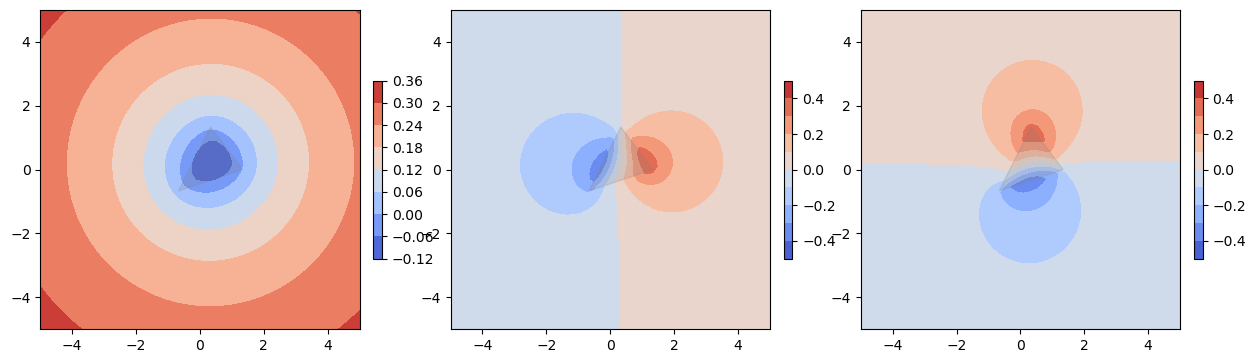

In [9]:
# Reference triangle geometry
triangle = np.array([[-1, -1.0], [2.0, -0.0], [0.5, 2.0]]) / 1.5

# Observation coordinates
nx = 50
ny = 50
x_obs, y_obs = np.meshgrid(np.linspace(-5, 5, nx), np.linspace(-5, 5, ny))
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

# Elastic parameters
mu = 1.0
# Applied force
fval = 1.0

u, sx, sy = bemcs.displacements_stresses_triangle_force_antiplane(
    triangle, x_obs, y_obs, fval, mu
)

levels = np.linspace(-0.5, 0.5, 11)
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.contourf(
    x_obs.reshape(ny, nx),
    y_obs.reshape(ny, nx),
    u.reshape(ny, nx),
    cmap="coolwarm",
)
plt.colorbar(fraction=0.026, pad=0.04, extend="both")
plt.fill(triangle[:, 0], triangle[:, 1], color="gray", alpha=0.2)
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(1, 3, 2)
plt.contourf(
    x_obs.reshape(ny, nx),
    y_obs.reshape(ny, nx),
    sx.reshape(ny, nx),
    cmap="coolwarm",
    levels=levels,
)
plt.colorbar(fraction=0.026, pad=0.04, extend="both")
plt.clim([-0.5, 0.5])
plt.fill(triangle[:, 0], triangle[:, 1], color="gray", alpha=0.2)
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(1, 3, 3)
plt.contourf(
    x_obs.reshape(ny, nx),
    y_obs.reshape(ny, nx),
    sy.reshape(ny, nx),
    cmap="coolwarm",
    levels=levels,
)
plt.colorbar(fraction=0.026, pad=0.04, extend="both")
plt.clim([-0.5, 0.5])
plt.fill(triangle[:, 0], triangle[:, 1], color="gray", alpha=0.2)
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

# Plot results from near-field and far-field

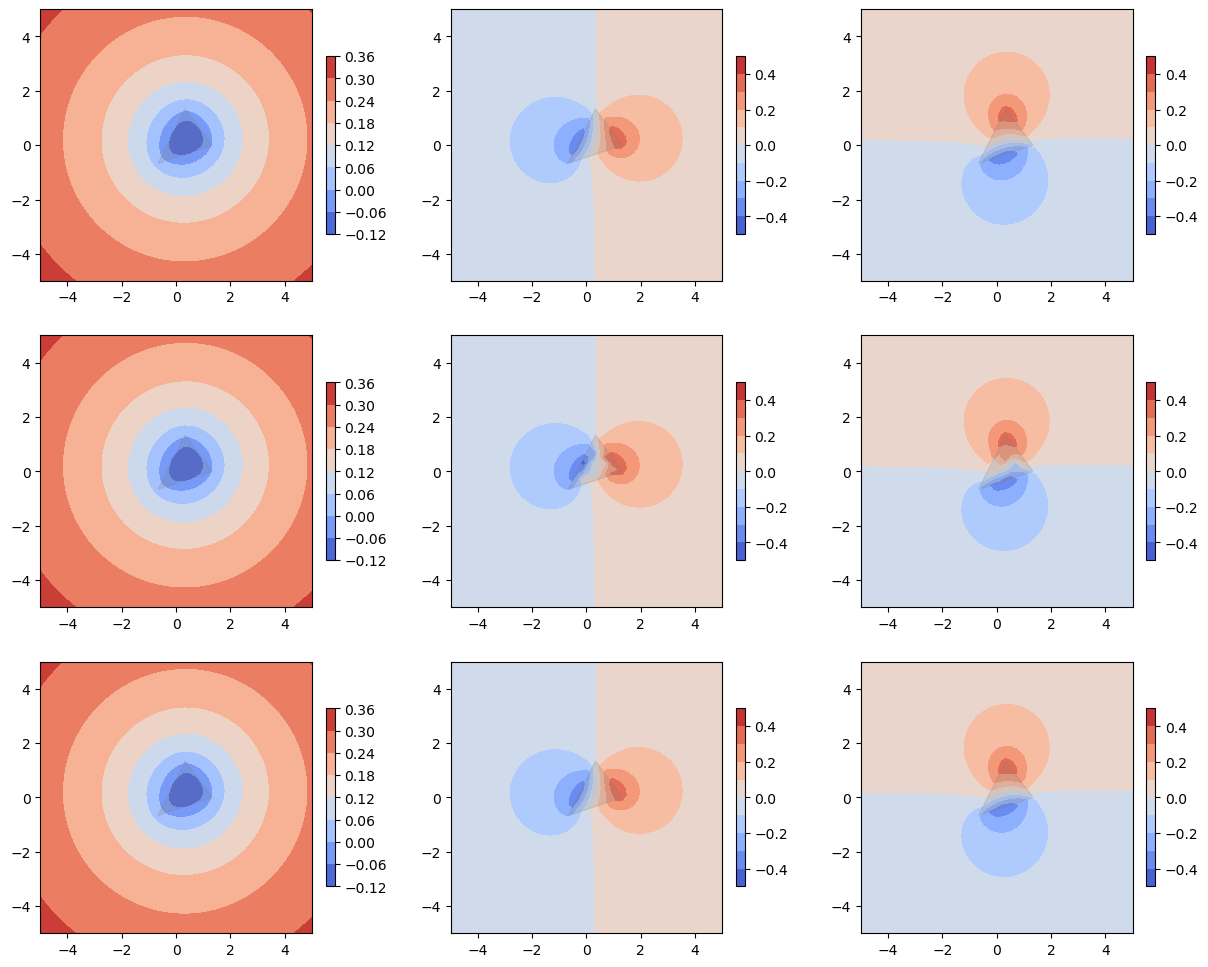

In [10]:
u_near, sx_near, sy_near = (
    bemcs.displacements_stresses_triangle_force_antiplane_nearfield(
        triangle, x_obs, y_obs, fval, mu
    )
)
u_far, sx_far, sy_far = bemcs.displacements_stresses_triangle_force_antiplane_farfield(
    triangle, x_obs, y_obs, fval, mu
)
# Plot results

plt.figure(figsize=(15, 12))
plt.subplot(3, 3, 1)
plt.contourf(
    x_obs.reshape(ny, nx),
    y_obs.reshape(ny, nx),
    u_near.reshape(ny, nx),
    cmap="coolwarm",
)
plt.colorbar(fraction=0.026, pad=0.04, extend="both")
plt.fill(triangle[:, 0], triangle[:, 1], color="gray", alpha=0.2)
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(3, 3, 2)
plt.contourf(
    x_obs.reshape(ny, nx),
    y_obs.reshape(ny, nx),
    sx_near.reshape(ny, nx),
    cmap="coolwarm",
    levels=levels,
)
plt.colorbar(fraction=0.026, pad=0.04, extend="both")
plt.clim([-0.5, 0.5])
plt.fill(triangle[:, 0], triangle[:, 1], color="gray", alpha=0.2)
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(3, 3, 3)
plt.contourf(
    x_obs.reshape(ny, nx),
    y_obs.reshape(ny, nx),
    sy_near.reshape(ny, nx),
    cmap="coolwarm",
    levels=levels,
)
plt.colorbar(fraction=0.026, pad=0.04, extend="both")
plt.clim([-0.5, 0.5])
plt.fill(triangle[:, 0], triangle[:, 1], color="gray", alpha=0.2)
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(3, 3, 4)
plt.contourf(
    x_obs.reshape(ny, nx),
    y_obs.reshape(ny, nx),
    u_far.reshape(ny, nx),
    cmap="coolwarm",
)
plt.colorbar(fraction=0.026, pad=0.04, extend="both")
plt.fill(triangle[:, 0], triangle[:, 1], color="gray", alpha=0.2)
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(3, 3, 5)
plt.contourf(
    x_obs.reshape(ny, nx),
    y_obs.reshape(ny, nx),
    sx_far.reshape(ny, nx),
    cmap="coolwarm",
    levels=levels,
)
plt.colorbar(fraction=0.026, pad=0.04, extend="both")
plt.clim([-0.5, 0.5])
plt.fill(triangle[:, 0], triangle[:, 1], color="gray", alpha=0.2)
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(3, 3, 6)
plt.contourf(
    x_obs.reshape(ny, nx),
    y_obs.reshape(ny, nx),
    sy_far.reshape(ny, nx),
    cmap="coolwarm",
    levels=levels,
)
plt.colorbar(fraction=0.026, pad=0.04, extend="both")
plt.clim([-0.5, 0.5])
plt.fill(triangle[:, 0], triangle[:, 1], color="gray", alpha=0.2)
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(3, 3, 7)
plt.contourf(
    x_obs.reshape(ny, nx),
    y_obs.reshape(ny, nx),
    u.reshape(ny, nx),
    cmap="coolwarm",
)
plt.colorbar(fraction=0.026, pad=0.04, extend="both")
plt.fill(triangle[:, 0], triangle[:, 1], color="gray", alpha=0.2)
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(3, 3, 8)
plt.contourf(
    x_obs.reshape(ny, nx),
    y_obs.reshape(ny, nx),
    sx.reshape(ny, nx),
    cmap="coolwarm",
    levels=levels,
)
plt.colorbar(fraction=0.026, pad=0.04, extend="both")
plt.clim([-0.5, 0.5])
plt.fill(triangle[:, 0], triangle[:, 1], color="gray", alpha=0.2)
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(3, 3, 9)
plt.contourf(
    x_obs.reshape(ny, nx),
    y_obs.reshape(ny, nx),
    sy.reshape(ny, nx),
    cmap="coolwarm",
    levels=levels,
)
plt.colorbar(fraction=0.026, pad=0.04, extend="both")
plt.clim([-0.5, 0.5])
plt.fill(triangle[:, 0], triangle[:, 1], color="gray", alpha=0.2)
plt.gca().set_aspect("equal", adjustable="box")
plt.show()